# Image Recommendation System
This notebook represents a python 3 implementation for image recommendation system.

## 1. Data pre-process
First, we make a folder **originalImages** and another folder **inputImages** in the working directory.

Second, we collect a lot of **.jpg** images into **originalImages** folder.

Finally, we will employ ResNet-18 using Pytorch, so we need to **resize** the original images to **normalized** 224x224 images and store them into **inputImages** folder.

In [1]:
import os
from PIL import Image
from torchvision import transforms

# needed input dimensions for the CNN
inputDim = (224, 224)
inputDir = "originalImages"
inputDirCNN = "inputImages"

os.makedirs(inputDirCNN, exist_ok = True)

transformationForCNNInput = transforms.Compose([transforms.Resize(inputDim)])

for imageName in os.listdir(inputDir):
    I = Image.open(os.path.join(inputDir, imageName))
    newI = transformationForCNNInput(I)

    # copy the rotation information metadata from original image and save, else your transformed images may be rotated
    # exif = I.info['exif']
    newI.save(os.path.join(inputDirCNN, imageName))
    
    newI.close()
    I.close()

## 2.Create embedding for each image in datasets with Resnet18
Let us first calculate the feature vectors with resnet18 on a CPU(or GPU). The input is normalized to the ImageNet mean values/standard deviation.

In [2]:
import torch
from tqdm import tqdm
from torchvision import models

# for this project we use no gpu, cuda= False and as model resnet18 to obtain feature vectors

class Img2VecResnet18():
    def __init__(self):
        
        self.device = torch.device("cpu")   # If you have gpu, use torch.device('cuda', 0)
        self.numberFeatures = 512        # You can change it anyway  <==>  embedding dim
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        
        # normalize the resized images as expected by resnet18
        # [0.485, 0.456, 0.406] --> normalized mean value of ImageNet, [0.229, 0.224, 0.225] std of ImageNet
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)

        def copyData(m, i, o): embedding.copy_(o.data)

        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()

        return embedding.numpy()[0, :, 0, 0]

    def getFeatureLayer(self):
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        return cnnModel, layer
        

# generate vectors(embedding) for all the images in the dataset
img2vec = Img2VecResnet18() 

allVectors = {}
print("Create embeddings, converting images to feature vectors:")
for image in tqdm(os.listdir(inputDirCNN)):
    I = Image.open(os.path.join(inputDirCNN, image))
    vec = img2vec.getVec(I)
    allVectors[image] = vec
    I.close() 


/Users/leiyuhan/miniconda3/envs/teset/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/leiyuhan/miniconda3/envs/teset/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Create embeddings, converting images to feature vectors:


100%|███████████████████████████████████████| 4738/4738 [01:15<00:00, 63.14it/s]


## 3. New Image, new embedding and calculate similarities with all images in our dataset.
For a new image which is not in our dataset, we should first to create embedding for it, and then calculate similarities(use Cosine similarity) with all images in our dataset.

We get top-5 similar images in our dataset for the new image.

In [9]:
import numpy as np
def find_most_similar_vectors(dictionary, vec):
    similarities = {}
    for key, value in dictionary.items():
        similarity = np.dot(value, vec) / (np.linalg.norm(value) * np.linalg.norm(vec))
        similarities[key] = similarity

    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    top5 = sorted_similarities[:6]

    most_similar_vectors = [(key, similarity) for key, similarity in top5]

    return most_similar_vectors


# NOTE: YOU CAN CHANGE THE query_image ANYWAY!!!
query_image = '01.jpg'
# vec = np.random.rand(512)
I = Image.open(query_image)
vec = img2vec.getVec(I)
I.close() 


# query top-5 similar vectors and keys
most_similar = find_most_similar_vectors(allVectors, vec)

# print results
for key, similarity in most_similar:
    print("Key:", key)
    print("Similarity Score:", similarity)
    print()

Key: 500.jpg
Similarity Score: 0.9044097

Key: 4042.jpg
Similarity Score: 0.90261036

Key: 4346.jpg
Similarity Score: 0.90186244

Key: 3599.jpg
Similarity Score: 0.90060544

Key: 2563.jpg
Similarity Score: 0.89984286

Key: 3859.jpg
Similarity Score: 0.89808124



## 4.Visualize the query image and its top-5 similar images in our dataset


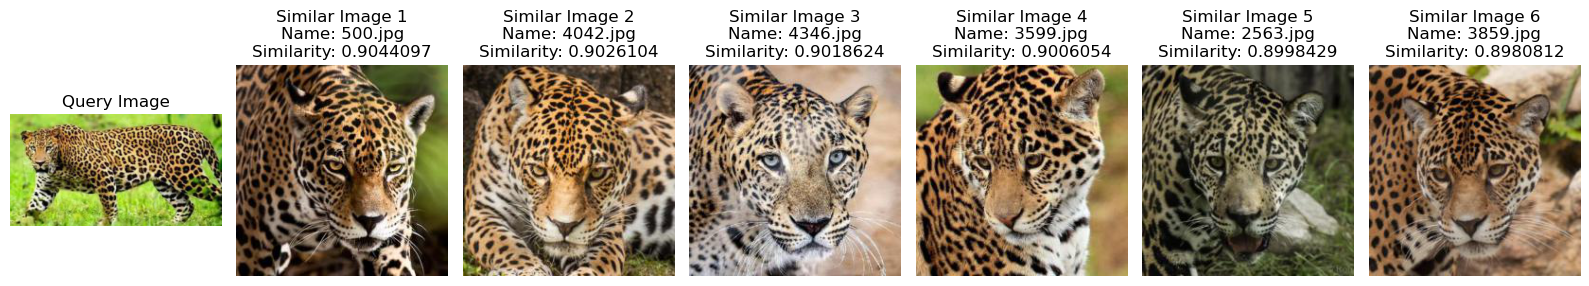

In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def show_similar_images(query_image_path, similar_images):
    fig, axs = plt.subplots(nrows=1, ncols=len(similar_images) + 1, figsize=(16, 4))
    # show query image
    query_image = Image.open(query_image_path)
    axs[0].imshow(query_image)
    axs[0].set_title("Query Image")

    # show top similar images
    for i, (name, similarity) in enumerate(similar_images, start=1):
        image = Image.open(os.path.join(inputDirCNN, name))
        axs[i].imshow(image)
        axs[i].set_title(f"Similar Image {i}\nName: {name}\nSimilarity: {similarity:.7f}")

    # hide the axes
    for ax in axs:
        ax.axis('off')

    # adjust the spacing between subplots.
    plt.tight_layout()

    # show image
     # plt.show()
# Displaying query image and similar images.
show_similar_images(query_image, most_similar)
